In [1]:
from model.sylber import Segmenter
import matplotlib.pyplot as plt
import soundfile as sf
import torchaudio
import torch
from IPython.display import Audio

/home/nicholas/miniconda3/envs/sylber/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Extracting Sylber Units and Visualizing Similarity Matrix


In [2]:
wav_file = "samples/sample.wav"
segmenter = Segmenter(model_ckpt="sylber.ckpt")


wav,_ = torchaudio.load(wav_file)
wav = (wav-wav.mean())/wav.std()
wav = wav.to(segmenter.device)
with torch.no_grad():
    hidden_states = segmenter.speech_model(wav,).last_hidden_state
hidden_states = hidden_states.squeeze(0).cpu().numpy()

outputs = segmenter(wav_file)

/data/nicholas/sylber-official/model/sylber.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_ckpt, map_location='cpu')


Pre-trained checkpoint loaded


In [3]:
wav,sr = sf.read(wav_file)

In [4]:
Audio(data=wav, rate=sr)

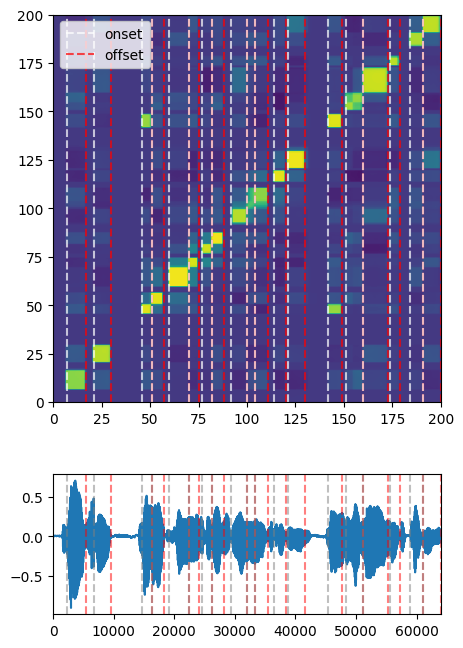

In [5]:
frame_num = 200

f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1],},figsize=(5,8))
a0.imshow(hidden_states@hidden_states.T)
need_legend=True
for s,e in outputs['segments']:
    a0.axvline(s*50, color='white',ls='--',alpha=.7,label='onset')
    a0.axvline(e*50, color='red', ls='--',alpha=0.7,label='offset')
    if need_legend:
        a0.legend()
        need_legend = False
a0.set_xlim(0,frame_num)
a0.set_ylim(0,frame_num)
a1.plot(wav[:int(sr*200/50)])
a1.set_xlim(0,int(sr*200/50))
for s,e in outputs['segments']:
    a1.axvline(s*sr, color='gray',ls='--',alpha=0.5,label='onset')
    a1.axvline(e*sr, color='red', ls='--',alpha=0.5,label='offset')

### Sylber Units Reconstruction

In [6]:
from model.segment_synthesis import SegmentSynthesis
import yaml
import torch

# Load YAML configuration
with open('sylber_configs/sylber_resynthesis.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Initialize SegmentSynthesis with the YAML configuration
sylber = SegmentSynthesis(**config).cuda().eval()

# Load checkpoint
result = torch.load("synthesis_sylber.ckpt", map_location='cpu')
modified_state_dict = {k.replace('net.', ''): v for k, v in result['state_dict'].items()}
sylber.load_state_dict(modified_state_dict, strict=False)

wav,_ = torchaudio.load(wav_file)
wav = (wav-wav.mean())/wav.std()
wav = wav.cuda()
with torch.no_grad():
    hidden_states = sylber.speech_model(wav,).last_hidden_state

outputs = segmenter(wav_file)
features = torch.zeros_like(hidden_states)
with torch.no_grad():
    for s,e in outputs['segments']:
        features[0,s:e] = hidden_states[0,s:e].mean(keepdim=True)
# Perform resynthesis on non-quantized segments


with torch.no_grad():
    resynth_outputs = sylber.resynthesize(features=features, steps=50, rand_scale=0.0, merge_threshold=0.8)
    
# # Encode and decode from wav
# with torch.no_grad():
#     resynth_outputs = sylber.resynthesize(input_values=wav, 
#                                           steps=10, rand_scale=0., merge_threshold=0.8)


/data/nicholas/sylber-official/model/flowmatching.py:173: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/data/nicholas/sylber-official/model/flowmatching.py:188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)
/tmp/ipykernel_1037679/1699435568.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allo

### Generate waveform using SPARC decoder

In [1]:
from sparc import load_model
import numpy as np
coder = load_model("en+", device="cuda", use_penn=True) 

# For extracting voice identity (embedding and mean pitch level from reference wavefile.
# The token-to-speech model is generating speaker-agnostic articulatory features from Sylber tokens.
# Here, we are showing using the original audio, but it can be any arbitrary speaker.

sparc_features = coder.encode(wav_file)

art = resynth_outputs[0][0].cpu().numpy()
ema = art[:,:12]
pitch = np.exp(art[:,12:13])*sparc_features['pitch_stats'][0] # pitch_mean should be predefined
loudness = art[:,13:]
loudness = (loudness-np.quantile(loudness,0.1)).clip(0)
resynth_wav = coder.decode(ema, pitch, loudness, sparc_features['spk_emb']) # spk_emb should be predefined


KeyboardInterrupt



In [8]:
Audio(data=resynth_wav, rate=coder.sr)